# Monitoring Neural Networks Exercise: Classifying Mushrooms 🍄🍴😋😵☠️

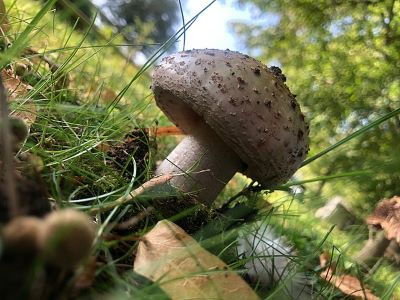

In this exercise, we will practice what we have learned about monitoring neural networks, building a network to classify edible and poisonous mushrooms. Using data adapted from the [UCI Mushroom Classification dataset](https://www.kaggle.com/uciml/mushroom-classification), train a model to separate tasty shrooms from deadly fungus!

## Part 1: Preprocessing

**Questions:**
1. Load the attached `mushrooms.csv` dataset and explore it lightly. You may view the data dictionary at the [Kaggle page](https://www.kaggle.com/uciml/mushroom-classification) for the dataset (under "About this file") - note that we are only using a subset of the features there. In particular, the target feature is 'class' (e=edible, p=poisonous).
2. Assuming e is class 0 and p is class 1, do we care more about precision or recall for this task?
3. Use `pd.get_dummies(...)` to one-hot encode the input features. For the target, use `1` for poisonous mushrooms and `0` for edible mushrooms. Perform a 70%-30% train-test split and save the data in variables `X_train, X_test, y_train, y_test`. Display the number of train and test samples.

In [47]:
import pandas as pd
import numpy as np



In [48]:
data= pd.read_csv("mushrooms.csv")
data.head()

,class,cap-shape,cap-surface,bruises,gill-attachment,gill-spacing,gill-size,stalk-shape,veil-color,ring-number,population
0,p,x,s,t,f,c,n,e,w,o,s
1,e,x,s,t,f,c,b,e,w,o,n
2,e,b,s,t,f,c,b,e,w,o,n
3,p,x,y,t,f,c,n,e,w,o,s
4,e,x,s,f,f,w,b,t,w,o,a


In [49]:
data['class'].unique()

array(['p', 'e'], dtype=object)

In [50]:
for i , j in data['class'].items():
  if j == 'p':
    data['class'][i] = 1
  else:
    data['class'][i] = 0

In [51]:
data.head()

,class,cap-shape,cap-surface,bruises,gill-attachment,gill-spacing,gill-size,stalk-shape,veil-color,ring-number,population
0,1,x,s,t,f,c,n,e,w,o,s
1,0,x,s,t,f,c,b,e,w,o,n
2,0,b,s,t,f,c,b,e,w,o,n
3,1,x,y,t,f,c,n,e,w,o,s
4,0,x,s,f,f,w,b,t,w,o,a


---
* In this case, we would like to reduce the amount of false negetives as we dont want to miss any Poisonous Mashroom in our batch. So Recall would be the best evaluation Metrix for this. 

---

In [52]:
data.columns

Index(['class', 'cap-shape', 'cap-surface', 'bruises', 'gill-attachment',
       'gill-spacing', 'gill-size', 'stalk-shape', 'veil-color', 'ring-number',
       'population'],
      dtype='object')

In [53]:
dummies= pd.get_dummies(data= data.drop("class", axis= 1), columns= data.drop('class', axis=1).columns)
dummies['class'] = data['class'].astype("int")

In [54]:
dummies.head(3)

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,bruises_f,bruises_t,gill-attachment_a,gill-attachment_f,gill-spacing_c,gill-spacing_w,gill-size_b,gill-size_n,stalk-shape_e,stalk-shape_t,veil-color_n,veil-color_o,veil-color_w,veil-color_y,ring-number_n,ring-number_o,ring-number_t,population_a,population_c,population_n,population_s,population_v,population_y,class
0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1
1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0


In [55]:
X= dummies.drop(["class"], axis= 1)
y= dummies['class']

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.3, random_state= 42)

In [57]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5686, 33), (2438, 33), (5686,), (2438,))

## Part 2: Baseline Model

4. We want to train a simple model to get a baseline result that we can compare our neural network to. Train a logistic regression model to predict the target (whether a mushroom is poisonous). Display the relevant metrics for your model calculated on the test set.
5. If we hold a huge dinner party with 100 guests and serve each guest one mushroom that our model said is edible, how many guests would we expect to be poisoned?

In [58]:
from sklearn.linear_model import LogisticRegression

In [59]:
y_test

1971    0
6654    1
5606    1
3332    0
6988    1
       ..
462     0
1956    0
3781    1
799     0
2402    0
Name: class, Length: 2438, dtype: int64

In [60]:
model= LogisticRegression()
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [61]:
model.score(X_test, y_test)

0.9315012305168171

In [62]:
from sklearn import metrics

In [63]:
model_preds= model.predict(X_test)

In [64]:
model_preds

array([0, 1, 1, ..., 1, 0, 0])

In [65]:
print("The Accuracy Score is: " , metrics.accuracy_score(y_test, model_preds))

The Accuracy Score is:  0.9315012305168171


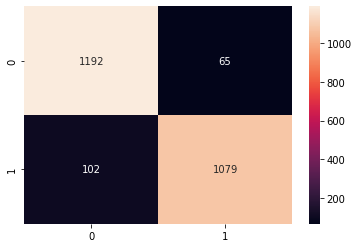

In [66]:
import seaborn as sns
confusion_mat= metrics.confusion_matrix(y_test, model_preds)
sns.heatmap(confusion_mat, annot=True, fmt='2g')

In [67]:
TP = confusion_mat[1, 1]
TN = confusion_mat[0, 0]
FP = confusion_mat[0, 1]
FN = confusion_mat[1, 0]

In [68]:
FN  # We falsely predicted the Poisonous mashrooms as non-poisnous!

102

## Part 3: Building and Monitoring a Neural Network

6. Create a simple MLP network (vanilla feedforward network) in Keras with the following two layers:
  * Dense(10, activation='relu')
  * Dense(1, activation='sigmoid')

   Explain in words why the activation functions make sense for this task, and why the last layer has only one unit.
7. Train your network on the training data using the Adam optimizer and batch size 4. Use use `X_test` and `y_test` in the `validation_data=` parameter of your Keras model's `fit(...)` method. Use the Keras `EarlyStopping` callback tracking validation loss to let the model decide how many epochs to train for. Make sure the best weights are restored at the end of training.
8. Display two plots:
  * Train and validation loss per epoch
  * Train and validation accuracy per epoch
  
  Make sure to include a legend that shows which curve is train loss/accuracy and which is validation loss/accuracy.

9. If we use this model for our dinner party from question 5, how many guests do we expect to be poisoned? (Hint: Use `model.predict(...)` and sklearn's classification report.)
10. Save your model as a Keras SavedModel using `.save(...)` with whatever filename you would like. What files does this create? (List them with command(s) or write a list of filenames.)
11. Using `tensorflow.keras.models.load_model(...)`, load the saved model into a new Python variable. Verify that it gives the same predictions on the test data as our original trained network.

In [69]:
import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras import Sequential

In [70]:
model= Sequential()
model.add(L.Dense(10, activation= 'relu'))
model.add(L.Dense(1, activation='sigmoid'))

# Here we have one unit in the last Layer, as there is only two classes either P or E. 
# ALSo, we are using Sigmoid Activation Function, because this is Binary Classification Task (Either 0 or 1).

In [71]:
from tensorflow.keras import metrics as M
model.compile(optimizer= 'adam', loss= 'BinaryCrossentropy', metrics=M.BinaryAccuracy(threshold=0.2))
model.fit(X_train, y_train, validation_data= [X_test, y_test], batch_size= 4, callbacks= tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5
                                ,restore_best_weights=True))

1422/1422 [==============================] - 4s 3ms/step - loss: 0.3352 - binary_accuracy: 0.7656 - val_loss: 0.2059 - val_binary_accuracy: 0.9348


Epoch 1/10
1422/1422 [==============================] - 4s 3ms/step - loss: 0.1659 - binary_accuracy: 0.9432 - val_loss: 0.1431 - val_binary_accuracy: 0.9467
Epoch 2/10
1422/1422 [==============================] - 4s 3ms/step - loss: 0.1211 - binary_accuracy: 0.9502 - val_loss: 0.1073 - val_binary_accuracy: 0.9491
Epoch 3/10
1422/1422 [==============================] - 4s 3ms/step - loss: 0.0899 - binary_accuracy: 0.9581 - val_loss: 0.0816 - val_binary_accuracy: 0.9557
Epoch 4/10
1422/1422 [==============================] - 4s 2ms/step - loss: 0.0678 - binary_accuracy: 0.9645 - val_loss: 0.0630 - val_binary_accuracy: 0.9610
Epoch 5/10
1422/1422 [==============================] - 4s 3ms/step - loss: 0.0511 - binary_accuracy: 0.9675 - val_loss: 0.0482 - val_binary_accuracy: 0.9614
Epoch 6/10
1422/1422 [==============================] - 4s 3ms/step - loss: 0.0390 - binary_accuracy: 0.9743 - val_loss: 0.0406 - val_binary_accuracy: 0.9721
Epoch 7/10
1422/1422 [==============================

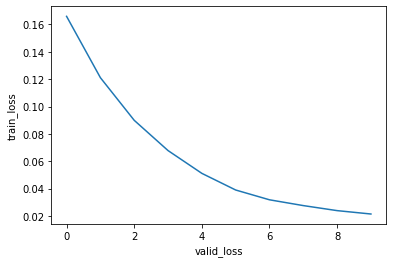

In [72]:
import matplotlib.pyplot as plt
history = model.fit(X_train, y_train, validation_data= [X_test, y_test], batch_size= 4, epochs= 10)

plt.plot(history.history['loss'])
plt.xlabel("valid_loss")
plt.ylabel("train_loss")
# plt.legend(['valid_loss', 'train_loss'])

plt.show()

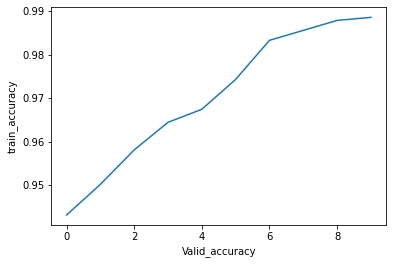

In [74]:
plt.plot(history.history['binary_accuracy'])
plt.xlabel("Valid_accuracy")
plt.ylabel("train_accuracy")
# plt.legend(['valid_accuracy', 'train_accuracy'])

plt.show()

plt.show()

In [77]:
#  By looking at the model accuracy , we can say only on eperson can die!
from sklearn import metrics
model_pred= model.predict(X_test)


In [78]:
model.save("keras_model")

INFO:tensorflow:Assets written to: keras_model/assets


` *  The files generated are : [Assets, variables, keras_metadata.pb, saved_model.pb]`

In [82]:
import os
load_model= tf.keras.models.load_model('keras_model')

In [83]:
load_model.predict(X_test)

array([[1.1187384e-04],
       [9.9996197e-01],
       [9.9960601e-01],
       ...,
       [9.9947548e-01],
       [5.0900877e-03],
       [1.5750825e-03]], dtype=float32)

In [84]:
model.predict(X_test)

array([[1.1187384e-04],
       [9.9996197e-01],
       [9.9960601e-01],
       ...,
       [9.9947548e-01],
       [5.0900877e-03],
       [1.5750825e-03]], dtype=float32)